In [1]:
from scipy.special import expit
from rbmpy.rbm import RBM
from rbmpy.sampler import VanillaSampler, DirtyCorrectionMulDimSampler,PartitionedSampler, ApproximatedSampler, LayerWiseApproxSampler,ApproximatedMulDimSampler, goodnight, orbm_goodnight, FullCorrectionMulDimSampler
from rbmpy.trainer import VanillaTrainier, ORBMTrainer
from rbmpy.performance import Result

import numpy as np
import rbmpy.datasets as datasets
import rbmpy.performance, pickle, rbmpy.rbm, os, math, logging

import rbmpy.plotter as pp
from rbmpy.datasets import SquareToyData
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

logger = logging.getLogger()
# Set the logging level to logging.DEBUG 
logger.setLevel(logging.INFO)

%matplotlib inline

In [2]:
def image_composition(a, b):
    return np.maximum(a,b)

## Dataset ##

First we construct a dataset of toy data. Back to the XOR case, so 2 bits. 

In [3]:
square_factory = SquareToyData()
sq_shape = (1,1)
img_size = (1,2)
dataset_one = square_factory.gen_training(sq_shape, img_size)

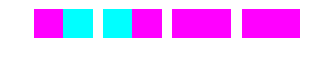

INFO:root:Training Dataset


In [4]:
dataset_composite = np.append(dataset_one,image_composition(dataset_one, np.flipud(dataset_one)), axis = 0)
pp.images(dataset_composite, color_range=(0,1))
logger.info("Training Dataset")

In [5]:
def plot_rbm_vanilla_dreams(rbm):
    reconstructions = goodnight(rbm, VanillaSampler(rbm),2000,200)[0]
    pp.plot_dict(reconstructions)

def plot_orbm_dreams(rbm_a, rbm_b, sampler):
    ab_orbm_dreams = orbm_goodnight(rbm_a,rbm_b,sampler, 2000,100)[0]
    pp.plot_dict(ab_orbm_dreams)
    return ab_orbm_dreams

def evaluate_orbm_training(num_hid, sampler_class, dataset_composite, epochs):
    
    (num_items, num_vis ) = datasets.squash_images(dataset_composite).shape
    rbm_a = RBM(num_hid, num_vis,num_items, zerod_bias=True)
    logger.warn("Using a single RBM here!!")
    rbm_b = rbm_a #RBM(num_hid, num_vis,num_items, zerod_bias= True)
    sampler = sampler_class(rbm_a.weights ,rbm_b.weights, rbm_a.hidden_bias, rbm_b.hidden_bias)
    trainer = ORBMTrainer(rbm_a,rbm_b, sampler)
    
    trainer.train(epochs,datasets.squash_images(dataset_composite), logging_freq=10)
    logger.info("RBM_A Dreams")
    plot_rbm_vanilla_dreams(rbm_a)
    logger.info("RBM_B Dreams")
    plot_rbm_vanilla_dreams(rbm_b)
    logger.info("ORBM Dreams (combined reconstructions)")
    plot_orbm_dreams(rbm_a, rbm_b, sampler)
    return (rbm_a, rbm_b)

In [6]:
rbm_a, rbm_b = evaluate_orbm_training(2, ApproximatedMulDimSampler, dataset_composite, int(1e3))

INFO:rbmpy.trainer:Created Progress logger for task - rbmpy.trainer
INFO:rbmpy.trainer:0.0% complete
INFO:rbmpy.trainer:10.0% complete
INFO:rbmpy.trainer:20.0% complete
INFO:rbmpy.trainer:30.0% complete
INFO:rbmpy.trainer:40.0% complete
INFO:rbmpy.trainer:50.0% complete
INFO:rbmpy.trainer:60.0% complete
INFO:rbmpy.trainer:70.0% complete
INFO:rbmpy.trainer:80.0% complete
INFO:rbmpy.trainer:90.0% complete
INFO:rbmpy.trainer:100% complete
INFO:root:RBM_A Dreams


KeyboardInterrupt: 

# An RBM trained on the same data... #

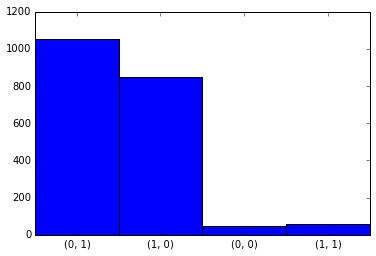

[[-4.57322864  5.33523904]
 [ 5.14522751 -3.28716355]]


In [6]:
pure_dataset = np.append(dataset_one, dataset_one, axis = 0)
(num_items, num_vis ) = datasets.squash_images(pure_dataset).shape
rbm_vanilla = RBM(2,num_vis,num_items)
van_sampler = VanillaSampler(rbm_vanilla)
van_trainer = VanillaTrainier(rbm_vanilla,van_sampler)
van_trainer.train(int(1e4), datasets.squash_images(pure_dataset))
plot_rbm_vanilla_dreams(rbm_vanilla)
print(rbm_vanilla.weights)
original_van_weights = np.copy(rbm_vanilla.weights)

INFO:root:Approx ORBM Generative Samples - Free Phase Sampling


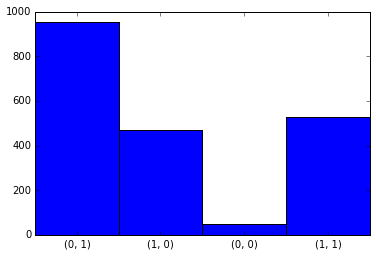

Counter({(0, 1): 954, (1, 1): 530, (1, 0): 468, (0, 0): 48})

In [7]:
orbm_sampler = ApproximatedMulDimSampler(rbm_vanilla.weights ,rbm_vanilla.weights, rbm_vanilla.hidden_bias, rbm_vanilla.hidden_bias)
unapprox_sampler = FullCorrectionMulDimSampler(rbm_vanilla.weights ,rbm_vanilla.weights, rbm_vanilla.hidden_bias, rbm_vanilla.hidden_bias)
orbm_trainer = ORBMTrainer(rbm_vanilla,rbm_vanilla, unapprox_sampler)

dirty_sampler = DirtyCorrectionMulDimSampler(rbm_vanilla.weights ,rbm_vanilla.weights, rbm_vanilla.hidden_bias, rbm_vanilla.hidden_bias)
logger.info("Approx ORBM Generative Samples - Free Phase Sampling")
plot_orbm_dreams(rbm_vanilla, rbm_vanilla, orbm_sampler)

# logger.info("Un-Approx ORBM Generative Samples - Free Phase Sampling")
# plot_orbm_dreams(rbm_vanilla, rbm_vanilla, unapprox_sampler)
# logger.info("Dirty ORBM Generative Samples - Free Phase Sampling")
# plot_orbm_dreams(rbm_vanilla, rbm_vanilla, dirty_sampler)


In [14]:
print(original_van_weights)
orbm_trainer.train(100,datasets.squash_images(dataset_composite), logging_freq=50)
print(rbm_vanilla.weights)

INFO:rbmpy.trainer:Created Progress logger for task - rbmpy.trainer
INFO:rbmpy.trainer:0.0% complete
INFO:rbmpy.trainer:50.0% complete
INFO:rbmpy.trainer:100% complete


[[-4.57322864  5.33523904]
 [ 5.14522751 -3.28716355]]
[[-3.21263843  4.82490997]
 [ 4.41875295 -2.30142588]]


In [17]:
orbm_trainer.train(int(1e4),datasets.squash_images(dataset_composite), logging_freq=10)

INFO:rbmpy.trainer:Created Progress logger for task - rbmpy.trainer
INFO:rbmpy.trainer:0.0% complete
INFO:rbmpy.trainer:10.0% complete
INFO:rbmpy.trainer:20.0% complete
INFO:rbmpy.trainer:30.0% complete
INFO:rbmpy.trainer:40.0% complete
INFO:rbmpy.trainer:50.0% complete
INFO:rbmpy.trainer:60.0% complete
INFO:rbmpy.trainer:70.0% complete
INFO:rbmpy.trainer:80.0% complete
INFO:rbmpy.trainer:90.0% complete
INFO:rbmpy.trainer:100% complete


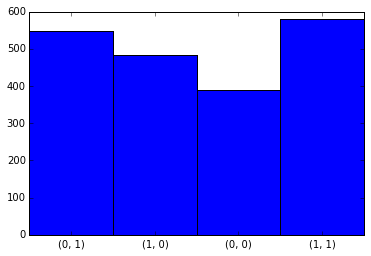

Counter({(1, 1): 580, (0, 1): 548, (1, 0): 483, (0, 0): 389})

In [18]:
plot_orbm_dreams(rbm_vanilla, rbm_vanilla, orbm_sampler)

In [19]:
print(original_van_weights)
print(rbm_vanilla.weights)
rbm_vanilla.weights - original_van_weights

[[-5.09800988  4.10930515]
 [ 3.70986568 -4.97462364]]
[[ 0.8930044   2.61385741]
 [ 2.57977601  0.66303963]]


array([[ 5.99101428, -1.49544774],
       [-1.13008967,  5.63766328]])

In [21]:
rbm_vanilla.weights[0,0] = -3
rbm_vanilla.weights[1,1] = -3
rbm_vanilla.weights[1,0] = 6
rbm_vanilla.weights[0,1] = 6

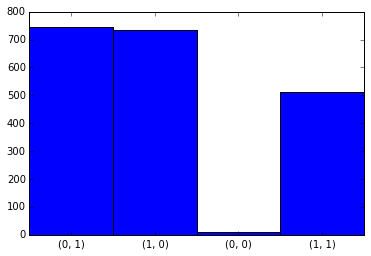

In [23]:
plot_rbm_vanilla_dreams(rbm_vanilla)


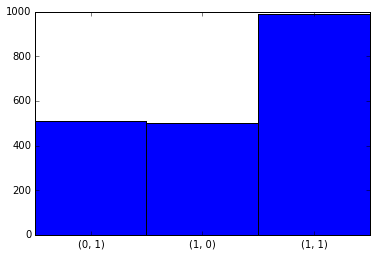

Counter({(1, 1): 988, (0, 1): 510, (1, 0): 502})

In [24]:
plot_orbm_dreams(rbm_vanilla, rbm_vanilla, orbm_sampler)

In [19]:
orbm_trainer.train(int(1e4),datasets.squash_images(dataset_composite), logging_freq=10)

INFO:rbmpy.trainer:Created Progress logger for task - rbmpy.trainer
INFO:rbmpy.trainer:0.0% complete
INFO:rbmpy.trainer:10.0% complete
INFO:rbmpy.trainer:20.0% complete
INFO:rbmpy.trainer:30.0% complete
INFO:rbmpy.trainer:40.0% complete
INFO:rbmpy.trainer:50.0% complete
INFO:rbmpy.trainer:60.0% complete
INFO:rbmpy.trainer:70.0% complete
INFO:rbmpy.trainer:80.0% complete
INFO:rbmpy.trainer:90.0% complete
INFO:rbmpy.trainer:100% complete


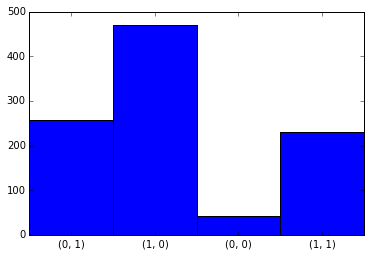

In [20]:
plot_orbm_dreams(rbm_vanilla, rbm_vanilla, orbm_sampler)

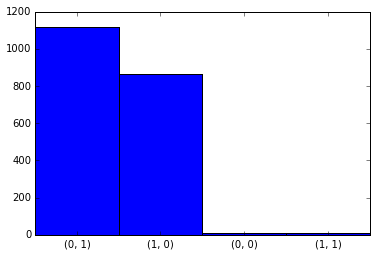

In [26]:
plot_rbm_vanilla_dreams(rbm_vanilla)

INFO:rbmpy.trainer:Created Progress logger for task - rbmpy.trainer
INFO:rbmpy.trainer:0.0% complete
INFO:rbmpy.trainer:10.0% complete
INFO:rbmpy.trainer:20.0% complete
INFO:rbmpy.trainer:30.0% complete
INFO:rbmpy.trainer:40.0% complete
INFO:rbmpy.trainer:50.0% complete
INFO:rbmpy.trainer:60.0% complete
INFO:rbmpy.trainer:70.0% complete
INFO:rbmpy.trainer:80.0% complete
INFO:rbmpy.trainer:90.0% complete
INFO:rbmpy.trainer:100% complete


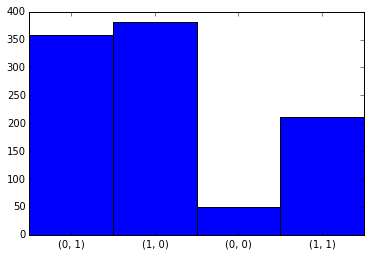

In [13]:
orbm_trainer.train(int(1e3),datasets.squash_images(dataset_composite), logging_freq=10)
plot_orbm_dreams(rbm_vanilla, rbm_vanilla, orbm_sampler)

INFO:rbmpy.trainer:Created Progress logger for task - rbmpy.trainer
INFO:rbmpy.trainer:0.0% complete
INFO:rbmpy.trainer:10.0% complete
INFO:rbmpy.trainer:20.0% complete
INFO:rbmpy.trainer:30.0% complete
INFO:rbmpy.trainer:40.0% complete
INFO:rbmpy.trainer:50.0% complete
INFO:rbmpy.trainer:60.0% complete
INFO:rbmpy.trainer:70.0% complete
INFO:rbmpy.trainer:80.0% complete
INFO:rbmpy.trainer:90.0% complete
INFO:rbmpy.trainer:100% complete
INFO:root:RBM_A Dreams


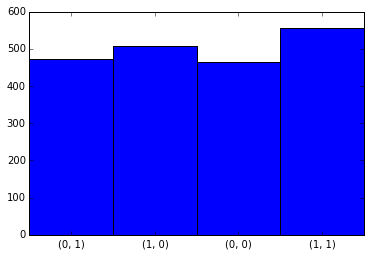

INFO:root:RBM_B Dreams


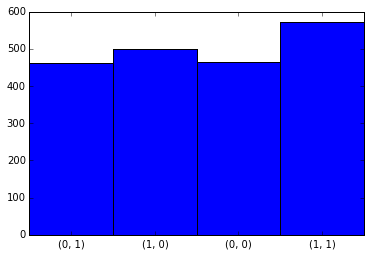

INFO:root:ORBM Dreams (combined reconstructions)


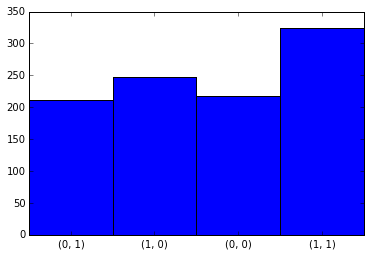

In [11]:
rbm_a, rbm_b = evaluate_orbm_training(2, FullCorrectionMulDimSampler, dataset_composite, int(1e3))

In [ ]:
def dream(self, v,model, num_gibbs = 1000):
    current_v = np.random.randint(2, size= model.visible.shape[1])
    dream_hid = np.random.randint(2, size= model.visible.shape[1])

    for i in range(num_gibbs):
        dream_hid = self.visible_to_hidden(current_v)
        current_v = self.hidden_to_visible(dream_hid)

    return current_v

def dream_clamped(self, clamped_v ,model_a, model_b, num_gibbs = 1000):
    a_vanilla = VanillaSampler(model_a)
    b_vanilla = VanillaSampler(model_b)

    a_dream_v = a_vanilla.dream(model_a, num_gibbs, return_sigmoid = False)
    b_dream_v = b_vanilla.dream(model_b, num_gibbs, return_sigmoid = False)


    a_dream_h = a_vanilla.visible_to_hidden(a_dream_v)
    b_dream_h = b_vanilla.visible_to_hidden(b_dream_v)

    phi_a =  np.dot(a_dream_h, model_a.weights)
    phi_b =  np.dot(b_dream_h, model_b.weights)
    sig_ab = expit(phi_a + phi_b)
    # print("phi_a {}\tphi_b {}\t\tdream_h_a {}\tdream_h_b {}\tSig_ab {}".format(phi_a, phi_b, a_dream_h, b_dream_h, sig_ab))
    return self.__bernoulli_trial__(sig_ab)



